## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Aug  7 14:04:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Install SAM2 and dependencies

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 349 (delta 29), reused 16 (delta 16), pack-reused 290
Receiving objects: 100% (349/349), 42.95 MiB | 21.05 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 39.9 kB/s eta 0:00:00
  Building edita

### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

### Imports

In [ ]:
import cv2
import torch
import base64

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

/content/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [ ]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load Model





In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
sam2_checkpoint = CHECKPOINT
CONFIG = "sam2_hiera_l.yaml"
model_cfg = CONFIG
sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
IMAGE_PATH = "/content/drive/MyDrive/Training-data/pictures_for_seg/600x600.jpg"

In [ ]:
image = Image.open(IMAGE_PATH)
image = np.array(image.convert("RGB"))

In [ ]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

## Points & Functions

In [ ]:
# Function to show masks
def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    if len(pos_points) > 0:
        ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    if len(neg_points) > 0:
        ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()


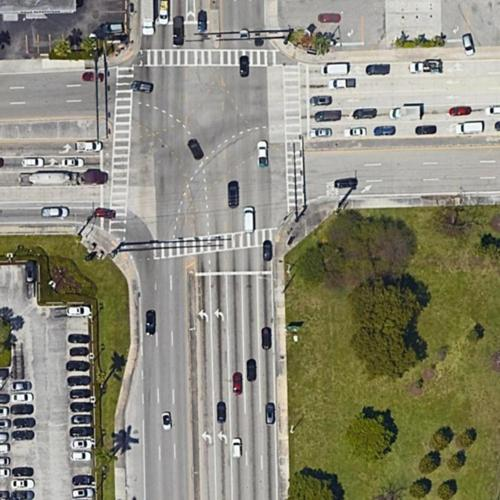

Dot marked at: (366.875, 436.875)
Dot marked at: (441.25, 438.125)
Dot marked at: (428.75, 461.875)
Dot marked at: (421.25, 484.375)
Dot marked at: (443.125, 488.75)
Dot marked at: (454.375, 464.375)
Dot marked at: (463.75, 438.75)
Dot marked at: (468.75, 127.5)
Dot marked at: (403.125, 111.875)
Dot marked at: (56.875, 177.5)


In [ ]:
import base64
from google.colab import output
from IPython.display import HTML

def draw_image_with_dots(image_path, dots=[]):
    image_data = get_base64_encoded_image(image_path)

    max_width = 1000
    max_height = 800

    img = Image.open(image_path)
    width, height = img.size

    scale = min(max_width / width, max_height / height)
    new_width = int(width * scale)
    new_height = int(height * scale)

    style_width = f"{new_width}px"
    style_height = f"{new_height}px"

    template = f"""
    <style>
        #image-container {{
            position: relative;
            width: {style_width};
            height: {style_height};
            text-align: left;
            overflow: hidden;
        }}
        #message {{
            position: absolute;
            bottom: -20px;
            left: 0;
            background-color: white;
            padding: 5px 10px;
            border-radius: 5px;
            box-shadow: 0 0 5px rgba(0, 0, 0, 0.5);
            z-index: 1;
        }}
        .dot {{
            position: absolute;
            width: 10px;
            height: 10px;
            border-radius: 50%;
            background-color: red;
        }}
    </style>
    <script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@3.9.0/dist/tf.min.js"></script>
    <div id="image-container">
        <img id="image" src="data:image/jpeg;base64,{image_data}" style="width:{style_width}; height:{style_height};">
        <div id="message"></div>
    </div>
    <script>
      var dots = {dots};
      var image = document.getElementById('image');
      var container = document.getElementById('image-container');
      var message = document.getElementById('message');
      var clickCount = 0;

      function drawDot(x, y) {{
        var dot = document.createElement('div');
        dot.className = 'dot';
        dot.style.left = x + 'px';
        dot.style.top = y + 'px';
        image.parentElement.appendChild(dot);
      }}

      image.onclick = function(event) {{
        if (clickCount >= 10) return;
        var rect = image.getBoundingClientRect();
        var x = event.clientX - rect.left;
        var y = event.clientY - rect.top;
        drawDot(x, y);
        google.colab.kernel.invokeFunction('store_dot', [x / {scale}, y / {scale}], {{}}); // Adjust x and y based on scale
        message.innerHTML = "Dot marked at: (" + (x / {scale}).toFixed(2) + ", " + (y / {scale}).toFixed(2) + ")";
        clickCount++;
      }};
    </script>
    """
    return template

def store_dot(x, y):
    global dots
    dots.append([x, y])
    print("Dot marked at:", (x, y))

output.register_callback('store_dot', store_dot)

def get_base64_encoded_image(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

dots = []

HTML(draw_image_with_dots(IMAGE_PATH))


## Multiple Objects Segmantion

In [ ]:
# Convert the dots to the required format
pts_batch = [np.array(dots).reshape(-1, 1, 2).astype(np.float32)]
labels_batch = [np.ones((len(dots), 1), dtype=np.int32)]  # Assuming label 1 for all points

print(pts_batch)
print(labels_batch)

In [ ]:
predictor.set_image_batch(img_batch)

In [ ]:
masks_batch, scores_batch, _ = predictor.predict_batch(
    pts_batch, labels_batch,
    box_batch=None,
    multimask_output=True
    )

# Select the best single mask per object
best_masks = []
for masks, scores in zip(masks_batch,scores_batch):
    best_masks.append(masks[range(len(masks)), np.argmax(scores, axis=-1)])

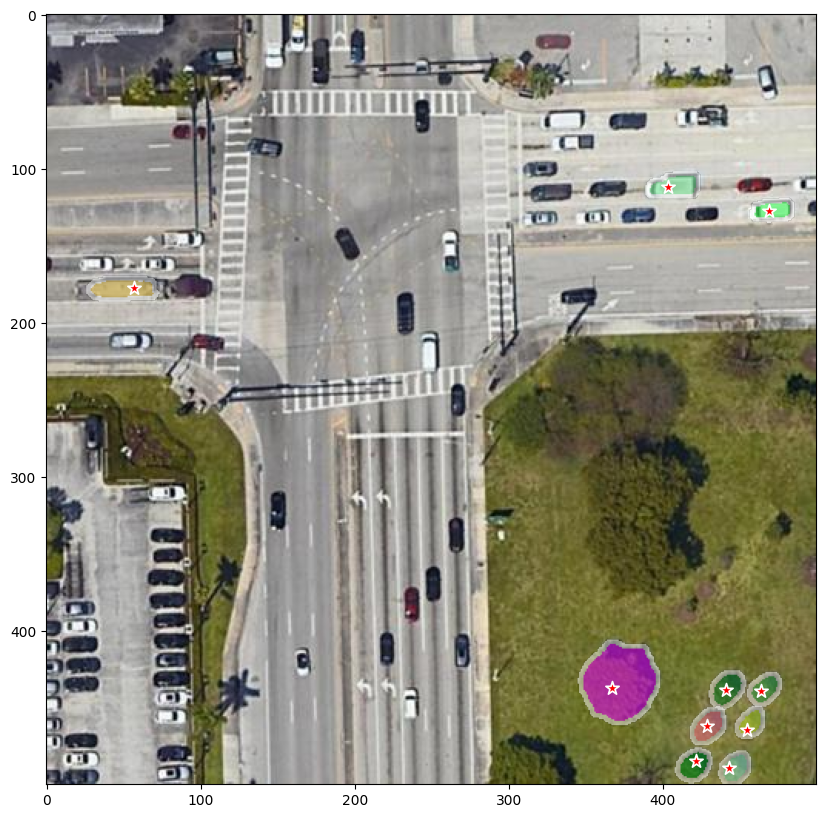

In [ ]:
for image, points, labels, masks in zip(img_batch, pts_batch, labels_batch, best_masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    show_points(points, labels, plt.gca())

## Single Object Segment

In [ ]:
# Assuming `dots` contains the points collected from your widget
points = np.array(dots)  # Convert list of points to numpy array


# Convert the points and labels to the required format
input_point = points
input_label = np.array([1] * len(input_point))  # Assuming label 1 for all points

In [ ]:
predictor.set_image(image)

In [ ]:
# Predict masks, scores, and logits
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Sort the masks based on scores
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [ ]:
masks.shape

(3, 500, 500)

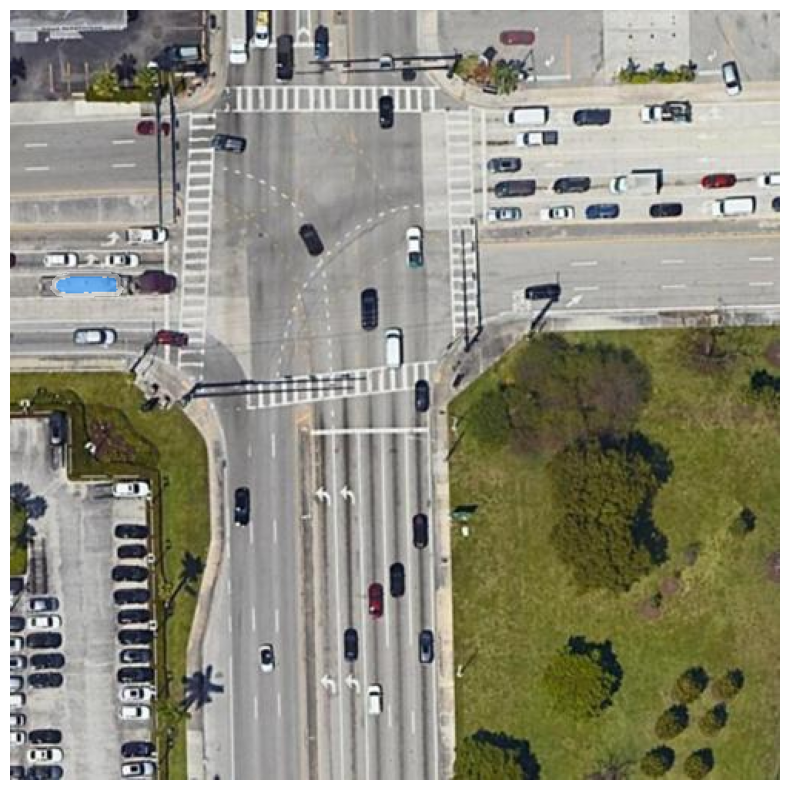

In [ ]:
# Display the first image with the mark
show_masks(image, [masks[0]], [scores[0]], input_labels=input_label)

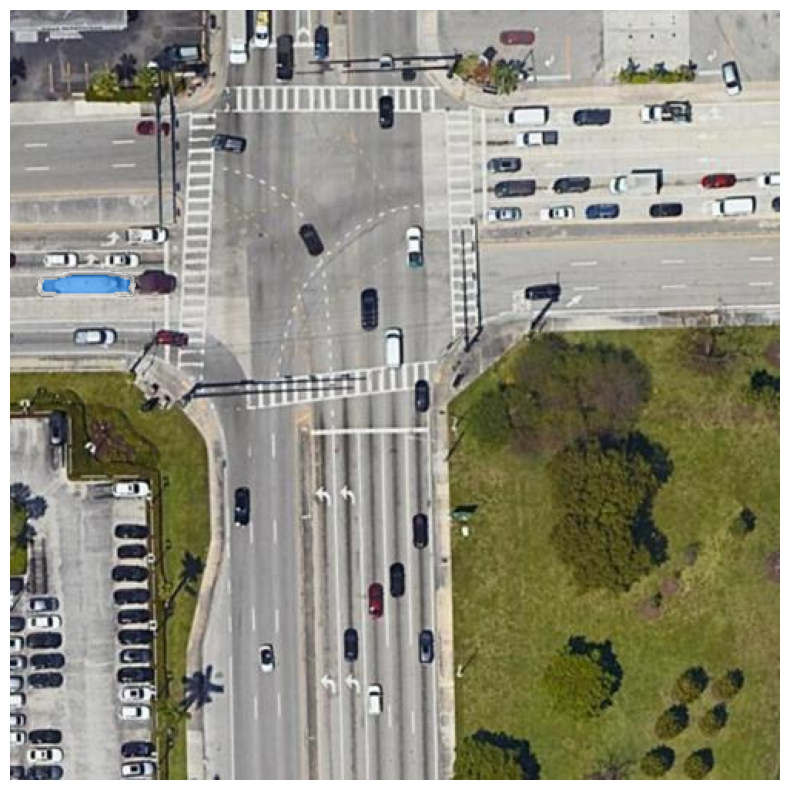

In [ ]:
# Display the second image with the mark
show_masks(image, [masks[1]], [scores[1]], input_labels=input_label)

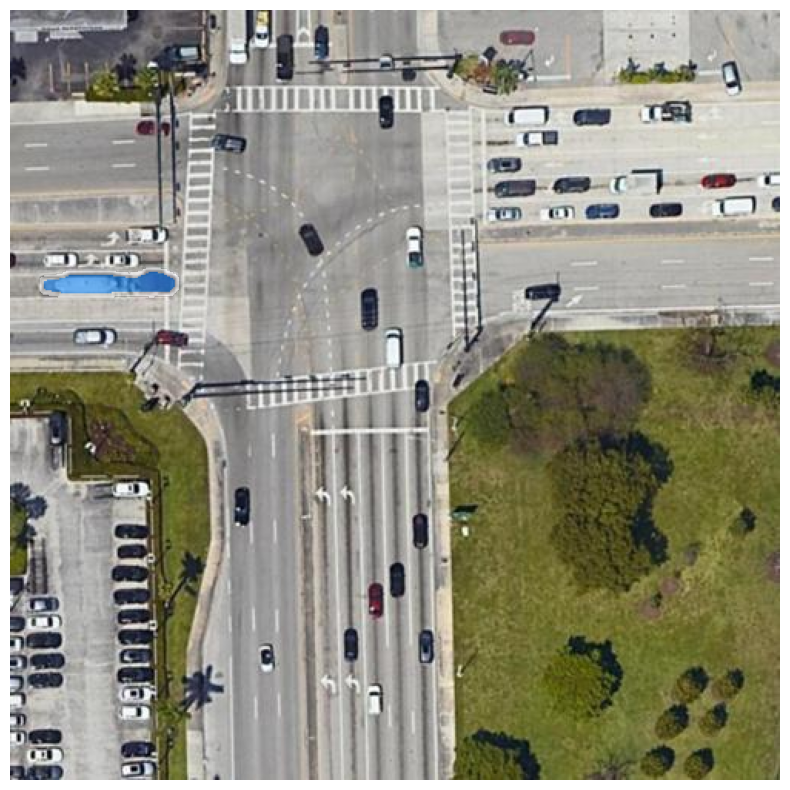

In [ ]:
# Display the third image with the mark
show_masks(image, [masks[2]], [scores[2]], input_labels=input_label)

# Extra


## SAM 2 SEG ALL

In [ ]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 10.9 MB/s eta 0:00:00


In [ ]:
import supervision as sv

In [ ]:
!mkdir -p {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data

In [ ]:
IMAGE_PATH = f"{HOME}/data/dog.jpeg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [ ]:
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [ ]:
import cv2
import tempfile
import os
import base64
# Save the image to a temporary file
def save_image_to_tempfile(image, file_format='png'):
    with tempfile.NamedTemporaryFile(delete=False, suffix=f'.{file_format}') as temp_file:
        temp_file_path = temp_file.name
        cv2.imwrite(temp_file_path, image)
    return temp_file_path

In [ ]:
sam2_result = mask_generator.generate(image_rgb)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

image_path = save_image_to_tempfile(annotated_image)
result_base64 = get_base64_encoded_image(image_path)

## Prompting with boxes

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

### Interactive box prompt

In [ ]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 13.4 MB/s eta 0:00:00


In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to **draw bounding box** on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 521, 'y': 713, 'width': 0, 'height': 0, 'label': ''},
 {'x': 679, 'y': 715, 'width': 0, 'height': 0, 'label': ''}]

**NOTE:** `Sam2ImagePredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format.

In [ ]:
default_box = [
    {'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
    {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
    {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
    {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

### Generate masks with SAM

**NOTE:** Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction. `SAM2ImagePredictor.predict` takes the following arguments:

- `point_coords` - `[np.ndarray or None]` - a `Nx2` array of point prompts to the model. Each point is in `(X,Y)` in pixels.
- `point_labels` - `[np.ndarray or None]` - a length `N` array of labels for the
point prompts. `1` indicates a foreground point and `0` indicates a
background point.
- `box` - `[np.ndarray or None]` - a length `4` array given a box prompt to the
model, in `[x_min, y_min, x_max, y_max]` format.
- `mask_input` - `[np.ndarray]` - a low resolution mask input to the model, typically coming from a previous prediction iteration. Has form `1xHxW`, where
for SAM, `H=W=256`.
- `multimask_output` - `[bool]` - if true, the model will return three masks.
For ambiguous input prompts (such as a single click), this will often
produce better masks than a single prediction. If only a single
mask is needed, the model's predicted quality score can be used
to select the best mask. For non-ambiguous prompts, such as multiple
input prompts, `multimask_output=False` can give better results.
- `return_logits` - `[bool]` - if true, returns un-thresholded masks logits
instead of a binary mask.
- `normalize_coords` - `[bool]` - if true, the point coordinates will be normalized to the range `[0,1]` and point_coords is expected to be wrt. image dimensions.

In [ ]:
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

masks = np.squeeze(masks)

### Results visualisation

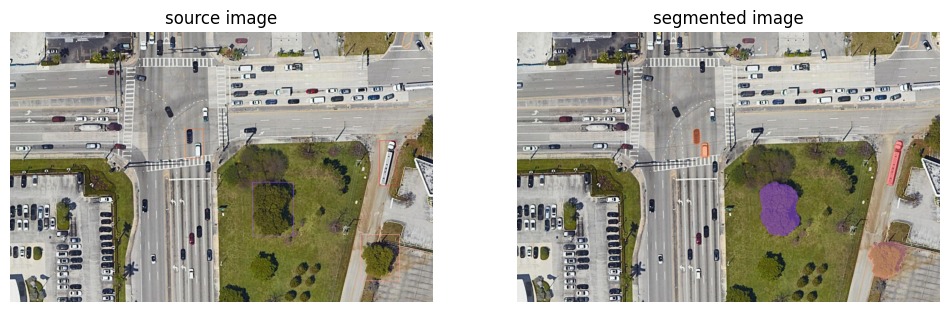

In [ ]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Prompting with points

**NOTE:** Execute cell below and use your mouse to **draw points** on the image 👇

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget


widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 521, 'y': 713, 'width': 0, 'height': 0, 'label': ''},
 {'x': 679, 'y': 715, 'width': 0, 'height': 0, 'label': ''}]

In [ ]:
default_box = [
    {'x': 330, 'y': 450, 'width': 0, 'height': 0, 'label': '1'},
    {'x': 191, 'y': 665, 'width': 0, 'height': 0, 'label': '1'},
    {'x': 86, 'y': 879, 'width': 0, 'height': 0, 'label': '0'},
    {'x': 425, 'y': 727, 'width': 0, 'height': 0, 'label': '0'}
]

points = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in points
])
input_label = np.ones(input_point.shape[0])

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

**NOTE:** With `multimask_output=True` (the default setting), SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When False, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

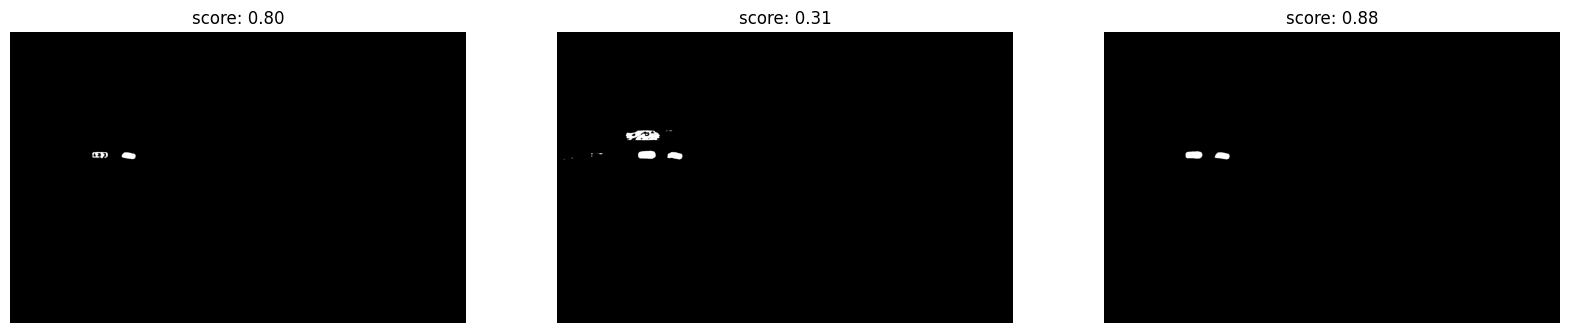

In [ ]:
sv.plot_images_grid(
    images=masks,
    titles=[f"score: {score:.2f}" for score in scores],
    grid_size=(1, 3),
    size=(20, 20)
)

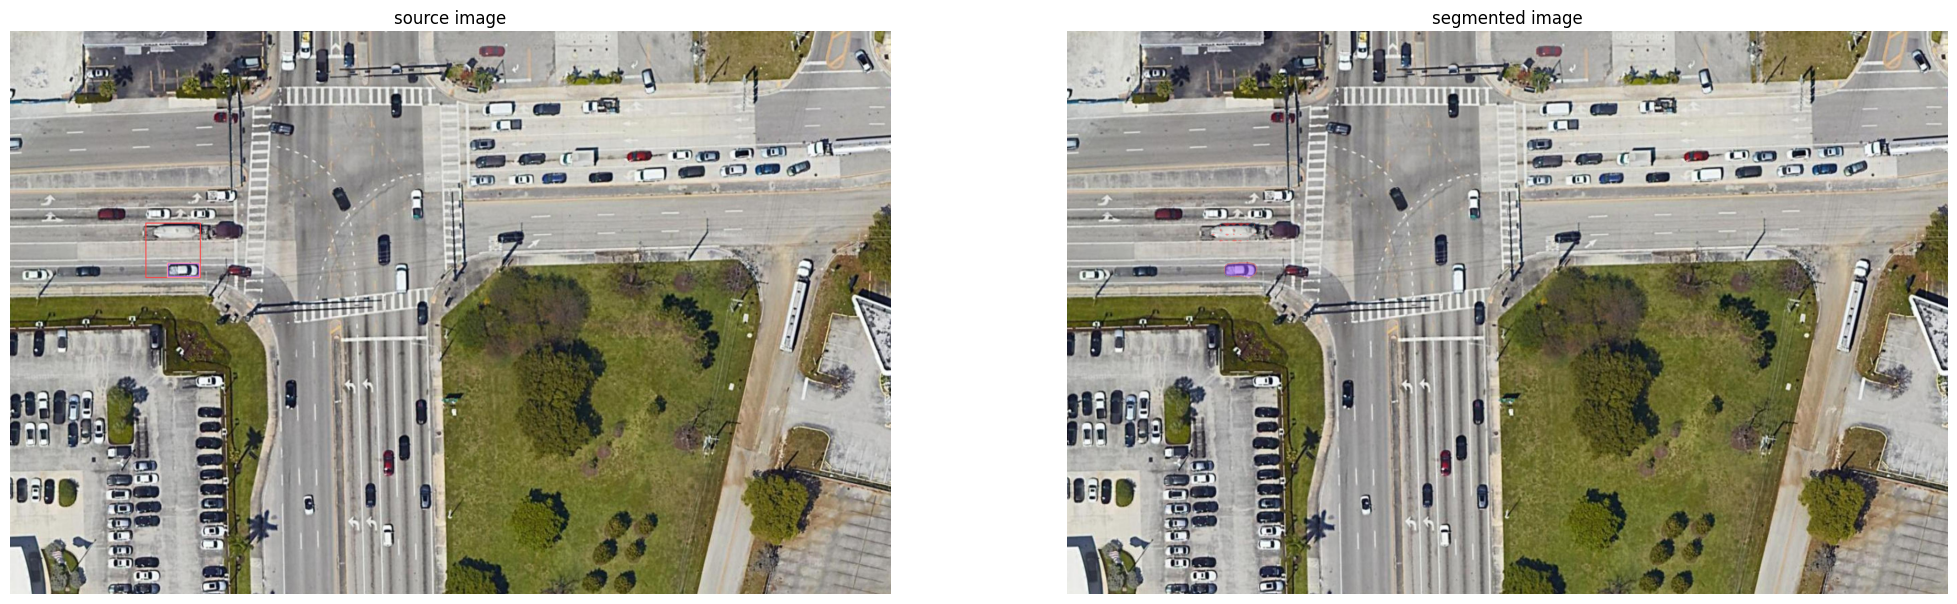

In [ ]:
# List of indices for the points you want to include
point_indices = [0, 1, 2]  # Update this list with the indices corresponding to the points

# Filter masks and coordinates based on the selected point indices
filtered_masks = masks[point_indices]
filtered_xyxy = sv.mask_to_xyxy(masks=filtered_masks)

# Create filtered detections with multiple points
filtered_detections = sv.Detections(
    xyxy=filtered_xyxy,
    mask=filtered_masks.astype(bool)
)

# Annotate the image with filtered detections
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=filtered_detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=filtered_detections)

# Plot the images
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    size=(25, 25),
    titles=['source image', 'segmented image']
)


# Web Connection

#  NGROK FULL CONNECTION


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Fri Aug 23 16:15:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = '/content/drive/MyDrive'
print("HOME:", HOME)

HOME: /content/drive/MyDrive


### Install SAM2 and dependencies

In [4]:
%cd /content/drive/MyDrive/segment-anything-2
!pip install -e .

/content/drive/MyDrive/segment-anything-2
Obtaining file:///content/drive/MyDrive/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86

### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [5]:
!mkdir -p {HOME}/checkpoints

### Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

### Imports

In [6]:
!pip install Flask-Cors
!pip install pyngrok

In [7]:
import os
import sys
import cv2
import torch
import numpy as np
import base64
import random
from io import BytesIO
from PIL import Image
from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok
import threading
import traceback
import matplotlib.pyplot as plt
import subprocess
import io
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

/content/drive/MyDrive/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [8]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load Model





In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"
sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)
predictor = SAM2ImagePredictor(sam2_model)

In [10]:
def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [11]:
# Set up ngrok
def start_ngrok():
    url = ngrok.connect(8000)
    print("ngrok tunnel URL is:", url)
    print(f"ngrok tunnel available at: {url}")

# Functions for image processing and segmentation
# Constants for resizing
MAX_WIDTH = 1024
MAX_HEIGHT = 768

def adjust_points(points, resize_ratio):
    adjusted_points = []
    for point in points:
        x = int(point['x'] * resize_ratio[0])
        y = int(point['y'] * resize_ratio[1])
        adjusted_points.append({'x': x, 'y': y, 'label': point.get('label', 0)})
    return adjusted_points


def resize_image(image, max_width, max_height):
    h, w = image.shape[:2]
    aspect_ratio = w / h
    if w > max_width:
        w = max_width
        h = int(w / aspect_ratio)
    if h > max_height:
        h = max_height
        w = int(h * aspect_ratio)
    return cv2.resize(image, (w, h))


def post_process_segmentation(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def get_image_from_base64(base64_str):
    try:
        encoded_data = base64_str.split(',')[1]
        nparr = np.frombuffer(base64.b64decode(encoded_data), np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError("Image decode failed")
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    except Exception as e:
        print(f"Error decoding image: {e}")
        return None

def get_base64_encoded_image(image_path):
    try:
        with open(image_path, "rb") as img_file:
            return base64.b64encode(img_file.read()).decode('utf-8')
    except Exception as e:
        print(f"Error encoding image: {e}")
        return None


def annotate_image(image, masks, mode='single', opacity=0.6):
    annotated_image = image.copy()

    if mode == 'multiple':
        # Generate a list of random colors, one for each mask
        colors = [
            [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
            for _ in range(len(masks))
        ]
        for mask, color in zip(masks, colors):
            mask = mask.astype(bool)  # Ensure the mask is boolean
            # Blend the color with the original image using the specified opacity
            annotated_image[mask] = (
                opacity * np.array(color, dtype=np.uint8) + (1 - opacity) * annotated_image[mask]
            ).astype(np.uint8)
    else:
        # Single object mode: Use green color
        color = np.array([0, 255, 0], dtype=np.uint8)  # Green color for the mask
        for mask in masks:
            mask = mask.astype(bool)  # Ensure the mask is boolean
            # Blend the green color with the original image using the specified opacity
            annotated_image[mask] = (
                opacity * color + (1 - opacity) * annotated_image[mask]
            ).astype(np.uint8)

    return annotated_image

In [12]:
app = Flask(__name__)
CORS(app, supports_credentials=True)

In [ ]:
@app.route('/segment', methods=['POST'])
def segment_image():
    try:
        data = request.get_json()
        image_base64 = data['imageData']
        points = data['points']
        mode = data.get('mode', 'single')  # Default to single object

        if not points or not isinstance(points, list):
            return jsonify({'error': 'Invalid points data'}), 400

        image_array = get_image_from_base64(image_base64)
        if image_array is None:
            return jsonify({'error': 'Invalid image data'}), 400

        # Resize image and get resize ratio
        original_height, original_width = image_array.shape[:2]
        resized_image = resize_image(image_array, MAX_WIDTH, MAX_HEIGHT)
        resized_height, resized_width = resized_image.shape[:2]
        resize_ratio = (resized_width / original_width, resized_height / original_height)

        temp_images_dir = os.path.join(os.getcwd(), 'temp_images')
        if not os.path.exists(temp_images_dir):
            os.makedirs(temp_images_dir)
        image_path = os.path.join(temp_images_dir, 'temp_image.jpg')

        cv2.imwrite(image_path, cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR))

        # Adjust points coordinates
        adjusted_points = adjust_points(points, resize_ratio)

        valid_points = []
        labels = []
        for point in adjusted_points:
            try:
                x, y, label = int(point['x']), int(point['y']), int(point['label'])
                if 0 <= x < resized_image.shape[1] and 0 <= y < resized_image.shape[0]:
                    valid_points.append((x, y))
                    labels.append(label)
            except KeyError as e:
                print(f"Error accessing point: {point}, error: {e}")

        input_point = np.array(valid_points)
        input_label = np.array(labels)

        if mode == 'multiple':
            # Convert the points and labels to the required format
            pts_batch = [np.array(input_point).reshape(-1, 1, 2).astype(np.float32)]
            labels_batch = [np.ones((len(input_point), 1), dtype=np.int32)]  # Assuming label 1 for all points

            img_batch = [resized_image]
            predictor.set_image_batch(img_batch)

            # Predict masks and scores
            masks_batch, scores_batch, _ = predictor.predict_batch(
                pts_batch, labels_batch,
                box_batch=None,
                multimask_output=True
            )

            # Select the best single mask per object
            best_masks = []
            for masks, scores in zip(masks_batch, scores_batch):
                best_masks.append(masks[np.arange(len(masks)), np.argmax(scores, axis=-1)])

            masks = [mask for sublist in best_masks for mask in sublist]

        else:
            predictor.set_image(resized_image)
            # Single object segmentation
            masks, scores, logits = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=True,
            )
            mask_input = logits[np.argmax(scores), :, :]
            masks, scores, _ = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                mask_input=mask_input[None, :, :],
                multimask_output=False,
            )

        if len(masks) > 0:
            # Pass mode parameter to annotate_image
            mask_annotated_image = annotate_image(resized_image, masks, mode)
            mask_image_path = os.path.join(temp_images_dir, '1.jpeg')
            cv2.imwrite(mask_image_path, cv2.cvtColor(mask_annotated_image, cv2.COLOR_RGB2BGR))
            mask_image = post_process_segmentation(mask_annotated_image)
            result_base64 = get_base64_encoded_image(mask_image_path)

            return jsonify({'status': 'success', 'segmentedImage': result_base64})
        else:
            return jsonify({'status': 'success', 'segmentedImage': None})

    except Exception as e:
        print(f"Error during processing: {e}")
        traceback.print_exc()
        return jsonify({'error': 'Server error', 'message': str(e)}), 500



if __name__ == '__main__':
    ngrok.set_auth_token("2k8KB2tIPNbEyiGDCqmZUYpPmqH_4hHzVr14pJTmmoezRBZKP")
    public_url = ngrok.connect(8000)
    print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:8000\"")
    app.run(host='0.0.0.0', port=8000)
https://3c59-35-247-122-59.ngrok-free.app/

 * ngrok tunnel "NgrokTunnel: "https://3c59-35-247-122-59.ngrok-free.app" -> "http://localhost:8000"" -> "http://127.0.0.1:8000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8000
 * Running on http://172.28.0.12:8000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [23/Aug/2024 16:24:12] "OPTIONS /segment HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Aug/2024 16:24:16] "POST /segment HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Aug/2024 16:24:26] "OPTIONS /segment HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Aug/2024 16:24:28] "POST /segment HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Aug/2024 16:24:48] "OPTIONS /segment HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Aug/2024 16:24:50] "POST /segment HTTP/1.1" 200 -
